# Loading packages

In [1]:
import metaknowledge as mk
import pandas as pd
import numpy as np
from random import randint
import datetime
import copy
from sklearn.cluster import KMeans

import umap
from scipy import stats

from tqdm import tqdm_notebook as tqdm

from enstop import EnsembleTopics

from scipy.sparse import coo_matrix, vstack
from scipy.sparse import csr_matrix
import scipy as scipy

import math
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

#For Tables:
from IPython.display import display
from IPython.display import Latex
pd.set_option('display.max_columns', 500)

#For R (ggplot2)
%load_ext rpy2.ipython

# from sklearn.externals.joblib import Memory
# memory = Memory(cachedir='/tmp', verbose=0)
# @memory.cache

import gc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.cluster import adjusted_rand_score, mutual_info_score

import re
from joblib import Parallel, delayed
import multiprocessing
#Embedding:
#Clustering:
import hdbscan
from sklearn.decomposition import TruncatedSVD


import umap
import colorcet as cc
from matplotlib import colors
from faerun import Faerun, host


# Loading Data

In [2]:
RC = mk.RecordCollection("dh_sample_2")#extraction1970_1999

# Removing unusable records & having a look at our data:


In [3]:
drc = pd.DataFrame(RC.makeDict()).merge(pd.DataFrame.from_dict(RC.forNLP()),left_index =True,right_index=True)
drc['source_no'] =[len(x) for x in drc['CR'].fillna(' ')]

drc = drc.dropna(subset=['title'])
# drc = drc[drc['LA'] == 'English']

drc = drc.dropna(subset=['abstract'])

corps =[[a for b in [[str(n).split(',')[0],str(n)] for n in x if not '[Anonymous]' in str(n)] for a in b] for x in drc['CR'].fillna(' ')] #keeping things nice and readable... #keeping things nice and readable...
vec = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,binary=True,min_df=3)
bow = vec.fit_transform(corps)
drc = drc.iloc[np.where(bow.sum(axis=1)>3)[0]]


drc = drc.reset_index()
drc['type'] = 'base' 

In [4]:
len(drc)

3746

In [5]:
RCdhd = mk.RecordCollection("dhd20_sample")

In [6]:
drcdhd = pd.DataFrame(RCdhd.makeDict()).merge(pd.DataFrame.from_dict(RCdhd.forNLP()),left_index =True,right_index=True)
drcdhd['type'] = 'dhd' 

In [7]:
drcdhd

,PT,AU,AF,BE,TI,SO,SE,LA,DT,CT,CY,CL,SP,AB,C1,RP,EM,OI,CR,NR,TC,Z9,U1,U2,PU,PI,PA,SN,BN,J9,PY,VL,BP,EP,PG,WC,SC,GA,UT,DA,HO,ID,GP,DE,DI,JI,IS,EI,PD,RI,OA,BA,BF,D2,FU,FX,MA,SI,AR,PM,HC,HP,PN,SU,EA,num-Authors,num-Male,num-Female,num-Unknown,id,year,title,keywords,abstract,type
0,S,"[Bernecker, D, Riess, C, Christlein, V, Angelo...","[Bernecker, David, Riess, Christian, Christlei...","[Weickert, J, Hein, M, Schiele, B]",Representation Learning for Cloud Classification,"PATTERN RECOGNITION, GCPR 2013",Lecture Notes in Computer Science,English,Proceedings Paper,35th German Conference on Pattern Recognition ...,"SEP 03-06, 2013","Saarbrucken, GERMANY","[Robert Bosch GmbH, Fraunhofer ITWM, Google Re...",Proper cloud segmentation can serve as an impo...,"[Univ Erlangen Nurnberg, Dept Comp Sci, Patter...","Bernecker, D (reprint author), Univ Erlangen N...","[david.bernecker@cs.fau.de, christian.riess@cs...","[Riess, Christian/0000-0002-5556-5338]","[Bengio Y., 2012, ARXIV12065538, Bernecker D.,...",15.0,6.0,6.0,[0],[0],SPRINGER-VERLAG BERLIN,BERLIN,"HEIDELBERGER PLATZ 3, D-14197 BERLIN, GERMANY",0302-9743,"[978-3-642-40601-0, 978-3-642-40602-7]",LECT NOTES COMPUT SC,2013.0,8142,395,404,10.0,"[Computer Science, Artificial Intelligence, Co...",[Computer Science],BJN38,WOS:000329236100042,[2020-02-10],None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5,4,1,0,WOS:000329236100042,2013,Representation Learning for Cloud Classification,,proper cloud segmentation can serve as an impo...,dhd
1,B,"[Messerli, T, Yu, D]","[Messerli, Thomas, Yu, Di]","[Askin, R, Diederich, C, Bieri, A]",Multimodal construction of soccer-related humo...,"AESTHETICS, POETICS, AND RHETORIC OF SOCCER",Routledge Research in Sport Culture and Society,English,Proceedings Paper,Conference on Beautiful Game - The Poetics and...,"JUN 30-JUL 02, 2016","Univ Basel, Basel, SWITZERLAND","[Swiss Assoc N Amer Studies, Swiss Acad Humani...",None,"[Univ Basel, Basel, Switzerland., Univ Basel, ...","Messerli, T (reprint author), Univ Basel, Base...",None,None,"[Attardo S, 2011, PRAGMAT COGN, V19, P224, DOI...",25.0,1.0,1.0,[0],[0],ROUTLEDGE,ABINGDON,"2 PARK SQ, MILTON PARK, ABINGDON OX14 4RN, OXF...",None,"[978-1-351-18040-5, 978-0-8153-8573-8]",ROUTL RES SPORT CULT,2018.0,None,227,255,29.0,"[Humanities, Multidisciplinary, Hospitality, L...","[Arts & Humanities - Other Topics, Social Scie...",BL5WH,WOS:000452824500013,[2020-02-12],Univ Basel,"[SOCIAL MEDIA, DISCOURSE, PARTICIPATION, CONVE...",None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2,1,0,1,WOS:000452824500013,2018,Multimodal construction of soccer-related humo...,SOCIAL MEDIA|DISCOURSE|PARTICIPATION|CONVERSAT...,,dhd
2,S,"[Christlein, V, Gropp, M, Fiel, S, Maier, A]","[Christlein, Vincent, Gropp, Martin, Fiel, Ste...",None,Unsupervised Feature Learning for Writer Ident...,2017 14TH IAPR INTERNATIONAL CONFERENCE ON DOC...,Proceedings of the International Conference on...,English,Proceedings Paper,14th IAPR International Conference on Document...,"NOV 09-15, 2017","Kyoto, JAPAN","[IAPR, HITACHI, Sansan, FXPAL, GLORY, Media Dr...",Deep Convolutional Neural Networks (CNN) have ...,"[Friedrich Alexander Univ Erlangen Nurnberg, P...","Christlein, V (reprint author), Friedrich Alex...","[vincent.christlein@fau.de, martin.gropp@fau.d...","[Fiel, Stefan/0000-0001-5033-6723]","[Arandjelovic R, 2013, PROC CVPR IEEE, P1578, ...",42.0,5.0,5.0,[0],[0],IEEE,NEW YORK,"345 E 47TH ST, NEW YORK, NY 10017 USA",1520-5363,[978-1-5386-3586-5],PROC INT CONF DOC,2017.0,None,991,997,7.0,"[Computer Science, Artificial Intelligence, En...","[Computer Science, Engineering]",BM5CX,WOS:000464822500155,[2020-02-10],None,None,IEEE,"[unsupervised feature learning, writer identif...",10.1109/ICDAR.2017.165,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,4,4,0,0,WOS:0004648

In [8]:
drc=pd.concat([drc,drcdhd])
drc = drc.reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [9]:
len(drc)

4317

# Vectorizing:

In [10]:
# ########### Cited Works - Features ############



# drc['timestamp'] = pd.to_numeric(drc["year"], errors='coerce') + drc["PD"].fillna(0).replace('', 0, regex=True)/12

# def processInput(R):
#     d = list(set(R.getCitations().get("citeString")))
#     citedAU = list(set(R.getCitations().get("author")))
#     return d, citedAU
 
# num_cores = multiprocessing.cpu_count()


# results = Parallel(n_jobs=num_cores)(delayed(processInput)(R) for R in RC)


# d, citedAU = map(list, zip(*results))


# drc["citedAU"] = citedAU
# drc["citestring"] = d
# #print(d[0])
# authorslist = ['§'.join(filter(None,x)) for x in list(d)] 
# #print(authorslist[0])

# # vec = TfidfVectorizer(token_pattern=r'(?<=[^|§])[\s\w,\.:;]+(?=[$|§])')
# vec = CountVectorizer(token_pattern=r'(?<=[§])[\s\w,\.:;\/\[\]-]+(?=[§])',binary=True, min_df = 2)#)


# Xrc = vec.fit_transform(authorslist)

# Filtering:
There are always a few thousand unconnencted redords, citing only stuff noone else cites. We can get rid of them by doing a umap embedding and removing everything that forms a small ball at the side. (Not sure whether that's the best method though.)

In [11]:
# corps = [[a for b in [[str(n).split(',')[0],str(n)] for n in x] for a in b] for x in drc['CR'].fillna(' ')] #keeping things nice and readable...
# vec = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,binary=False)#,max_df=1000)

# bow = vec.fit_transform(corps)
# from sklearn.decomposition import TruncatedSVD
# SVD = TruncatedSVD(n_components= 100, n_iter=7, random_state=42)
# XSVD = SVD.fit_transform(bow)
# print(SVD.explained_variance_ratio_.sum())


In [12]:
# twodmap = umap.UMAP(n_components= 2,metric="cosine"
#                     ,n_neighbors=6,
#                       min_dist=0.001,
#                     verbose=True
#                    ).fit(XSVD)

In [ ]:
# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=400,min_samples =400).fit(twodmap.embedding_)
# print(len(set(clusterer.labels_)))
# import matplotlib as mpl
# cmap = mpl.cm.cool
# plt.scatter(twodmap.embedding_[:, 0], twodmap.embedding_[:, 1], c=clusterer.labels_, cmap='Dark2', s=1)


In [ ]:
# core_cluster = pd.DataFrame(pd.DataFrame(clusterer.labels_)[0].value_counts()).idxmax()
# where_core = list(np.where(clusterer.labels_ == core_cluster[0])[0])
# drc = drc.ix[where_core].reset_index()


# And now for the real embedding:

In [ ]:
# # corps = [[str(n) for n in x] for x in drc['CR'].fillna(' ')]
# # vec = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,binary=True)

# corps = [[a for b in [[str(n).split(',')[0],str(n)] for n in x] for a in b] for x in drc['CR'].fillna(' ')] #keeping things nice and readable...
# vec = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,binary=False)#,max_df=1000)
# bow = vec.fit_transform(corps)
# SVD = TruncatedSVD(n_components= 300, n_iter=7, random_state=42)
# XSVD = SVD.fit_transform(bow)

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
# corps = [[n.ID() for n in x] for x in drc['CR'].fillna(' ')] 
#[[str(n) for n in x if not 'Anonymous' in str(n)] for x in drc['CR'].fillna(' ')] #removing anonymous sources
corps =[[a for b in [[str(n).split(',')[0],str(n)] for n in x if not '[Anonymous]' in str(n)] for a in b] for x in drc['CR'].fillna(' ')] #keeping things nice and readable...
#[[str(n) for n in x if not '[Anonymous]' in str(n)] for x in drc['CR'].fillna(' ')] 

#[[a for b in [[str(n).split(',')[0],str(n)] for n in x] for a in b] for x in drc['CR'].fillna(' ')] #keeping things nice and readable...

# corps = [[', '.join(str(n).split(',')[0:2]) for n in x] for x in drc['CR'].fillna(' ')]#shorten sources for robustness?
#[[str(n) for n in x] for x in drc['CR'].fillna(' ')] 
vec = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,binary=False,min_df=2)
bow = vec.fit_transform(corps)
print(pd.DataFrame(bow.sum(axis=0),columns=vec.get_feature_names()).T[0].sort_values())
SVD = TruncatedSVD(n_components= 150, n_iter=7, random_state=42)
XSVD = SVD.fit_transform(bow)


text = drc['TI'].apply(str)+drc['abstract'].apply(str)
drc['text_to_embed'] = text
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed(list(drc['text_to_embed'].apply(str)))


fit1 = umap.UMAP(metric='cosine',
                         n_neighbors=15,
                         min_dist=0.0,
                         random_state=42,
                         verbose=True,learning_rate=0.9,
#                          learning_rate=0.6,
#                          negative_sample_rate=40,
#                          init=init
                        ).fit(XSVD[:,6:])

fit2 = umap.UMAP(metric='cosine',n_neighbors=25,
                         min_dist=0.0,
                         random_state=42,
                         verbose=True).fit(embeddings)
intersection = umap.umap_. general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=0.5)
intersection = umap.umap_.reset_local_connectivity(intersection)
to_cluster = umap.umap_.simplicial_set_embedding(data=fit1._raw_data, 
                                                   graph=intersection,
                                                   n_components= 2,#fit1.n_components, 
                                                   initial_alpha = fit1._initial_alpha, 
                                                   a=fit1._a,
                                                   b=fit1._b,
                                                   init='spectral',
                                                gamma=fit1.repulsion_strength, 
                                                   negative_sample_rate=fit1.negative_sample_rate,
                                                n_epochs=300,
                                                   random_state=np.random,
                                                   metric=fit1.metric, 
                                                metric_kwds=fit1._metric_kwds,
                                                   verbose=True)



Parikka Jussi, 2015, A GEOLOGY OF MEDIA                                                                                                   0.120654
Kirby V, 2011, QUANTUM ANTHR LIFE L                                                                                                       0.120654
Lonneker B., 2005, P 17 JOINT INT C ASS, P126                                                                                             0.129737
Lonneker B.                                                                                                                               0.129737
Eisele JC, 1997, LANGUAGE, V73, P751, DOI 10.2307/417325                                                                                  0.131210
Garsiel M.                                                                                                                                0.131210
Garsiel M., 1991, BIBLICAL NAMES LIT S                                                                                

Name: 0, Length: 29733, dtype: float64
UMAP(a=None, angular_rp_forest=False, b=None,
   force_approximation_algorithm=False, init='spectral', learning_rate=0.9,
   local_connectivity=1.0, low_memory=False, metric='cosine',
   metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
   output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
   set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
   target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
   transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Fri Feb 28 16:43:46 2020 Finding Nearest Neighbors
Fri Feb 28 16:43:46 2020 Building RP forest with 8 trees
Fri Feb 28 16:43:46 2020 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
Fri Feb 28 16:43:47 2020 Finished Nearest Neighbor Search
Fri Feb 28

C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\umap\spectral.py:243: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Feb 28 16:43:57 2020 Finished embedding
UMAP(a=None, angular_rp_forest=False, b=None,
   force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
   local_connectivity=1.0, low_memory=False, metric='cosine',
   metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
   n_neighbors=25, negative_sample_rate=5, output_metric='euclidean',
   output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
   set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
   target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
   transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Fri Feb 28 16:43:

C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\umap\spectral.py:243: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  300 epochs
	completed  30  /  300 epochs
	completed  60  /  300 epochs
	completed  90  /  300 epochs
	completed  120  /  300 epochs
	completed  150  /  300 epochs
	completed  180  /  300 epochs
	completed  210  /  300 epochs
	completed  240  /  300 epochs
	completed  270  /  300 epochs


In [30]:
# import umap
# from scipy import stats
# to_cluster = umap.UMAP(#random_state=42,
#                     n_components=2,
#                     n_neighbors=15,
#                     min_dist=0.0,
#                     metric='cosine',
#                     verbose=True)

# to_cluster.fit(XSVD[:,1:])#
# to_cluster = to_cluster.embedding_

In [31]:
from colorutils import Color,hex_to_hsv,hsv_to_hex
def get_sim_col(color):
    noise = np.random.normal(0,5,1)[0]
    smallnoise = np.random.normal(0,0.07,1)[0]

    col = hex_to_hsv(color)
    
    new_hue = sorted([0, int(col[0]+noise), 360])[1]
    new_saturation = sorted([0, col[1]+smallnoise, 1])[1]
    new_value = sorted([0, col[2]+smallnoise, 1])[1]
    
    col = (new_hue,new_saturation,new_value)
    return hsv_to_hex(col)

In [32]:
plt.figure(figsize=(10,10))

import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=12,min_samples =10).fit(to_cluster)
col_len = len(set(clusterer.labels_))-1
clustering_solution=clusterer.labels_



print(col_len)

146


<Figure size 720x720 with 0 Axes>

In [33]:
                                   
mylist = ["#01ccfc","#e28057","#38f6ff","#ed86a7","#5bc881","#ff9e99","#8ee591","#dfaab8","#b5f399","#27a7c6","#fed772","#69a4be","#d5cb61","#a9e7ff","#b4973b","#c0e1f1","#a19e37","#95f6c2","#ffb377","#7fa197","#ffcc80","#7da64e","#d0e9d3","#97a052","#c7edbf","#aa995e","#ceeda0","#ffd5a1","#89a367","#e9e795"]
meta_clusters = clusterer.single_linkage_tree_.get_clusters(0.2, min_cluster_size=40)
print(len(set(meta_clusters))-1)
color_scale = mylist[:len(set(meta_clusters))-1]#cc.b_glasbey_bw
meta_color_scale = ["#b09c84"] + color_scale
meta_colors = colors.LinearSegmentedColormap.from_list('cmap',list(meta_color_scale),len(list(meta_color_scale)))

23


In [34]:
small_clust_colors = []
# some uncaught bug with the color transfer....
for small_clust in range(0,len(list(set(clustering_solution)))-1):
    where_small_clust = np.where(clusterer.labels_==small_clust)[0]
    a = meta_clusters[where_small_clust]

    a = a[a!=-1]
    try:
        large_clust_color = color_scale[np.argmax(np.bincount(a))]
        small_clust_colors.append(get_sim_col(large_clust_color))
    except:
        small_clust_colors.append(mylist[randint(0, len(mylist)-1) ])
small_clust_colors = ["#b09c84"] +small_clust_colors
cmap = colors.LinearSegmentedColormap.from_list('cmap',small_clust_colors,len(small_clust_colors))


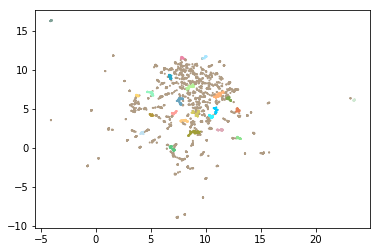

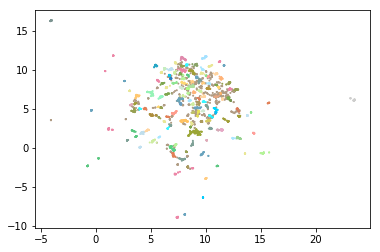

In [35]:
plt.scatter(to_cluster[:, 0], to_cluster[:, 1], s=1, c=meta_clusters, cmap=meta_colors)
plt.show()
plt.scatter(to_cluster[:, 0], to_cluster[:, 1], s=1, c=clusterer.labels_, cmap=cmap)
plt.show()

# Now, extract the data for the labeling of the clusters:

In [36]:
import yake
language = "en"
max_ngram_size = 2
deduplication_thresold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 20
drc['labels'] = 'Not assigned to a cluster.'


for cluster_num in tqdm(range(0,col_len)):
    w = np.where(clusterer.labels_==cluster_num)[0]
    text = ' '.join(drc['title'][w].apply(str))+' '.join(drc['abstract'][w].apply(str))
    text = text.lower().replace('article','').replace('digital','').replace('humanities','')
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)

    kws = []
    for kw in keywords:
        kws.append(kw[0])
    drc['labels'][w] = ', '.join(kws)
    print('alive')
#     https://github.com/LIAAD/yake

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive
alive



In [37]:
drc['journal_labels'] = 'noise'
for cluster_num in tqdm(range(0,col_len)):
    w = np.where(clusterer.labels_==cluster_num)[0]
    vc = drc['SO'][w].value_counts()
    top_journals = list(vc[vc > vc.max()/3].index)
    drc['journal_labels'][w] = ', '.join(top_journals).title() 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
# drc['sources_labels'] = 'noise'
# from collections import Counter

# for cluster_num in tqdm(range(0,col_len)):
#     w = np.where(clusterer.labels_==cluster_num)[0]
#     vc = drc['CR'][w]
#     vc = [j for i in vc for j in list(i)]
#     top_sources= [str(word) for word, word_count in Counter(vc).most_common(3)]
# #     print(top_sources)
# #     print(top_sources)
#     drc['sources_labels'][w] = ', '.join(top_sources).title() 


In [39]:
def lenjoin(l):
    if len(l)<=1:
        return l[0]
    if len(l) == 2:
        return ' and '.join(l)
    if len(l)>2:
        return ' and '.join([', '.join(l[:-1]),l[-1]])

drc['nicenames'] = [lenjoin([str(a).split(',')[0] for a in x]) for x in drc['AU'].fillna(' ')]
#[lenjoin(['. '.join(str(a).split(',')[::-1]).title() for a in x]) for x in drc['AU'].fillna(' ')]

drc['link'] = ['<br><b>Link: </b> <a target="_blank"  href="https://doi.org/' + str(x) + '"> Link registered: Please click! </a>' if x != None else '' for x in  drc['DI']]


In [40]:
drc['tooltip'] = ('<b>Title: </b>' + drc['title'] +
                  '<br><b>Year: </b>' + drc['year'].astype(str) +
                  '<br><b>Author: </b>' + drc['nicenames'] +
                  drc['link'] +
                '<br><b>Journal: </b>' + drc['SO'] +
                    '<br><b>Cluster-Keywords: </b><em>'+drc['labels']#pd.DataFrame([', '.join([str(n) for n in x]) for x in drc['CR'].fillna(' ')])[0]#labels
#                     '</em>'+'<br><b>Common Journals: </b>'+drc['journal_labels']+
#                     '</em>'+'<br><b>Common Articles: </b>'+drc['sources_labels']
                 )#drc['labels']#

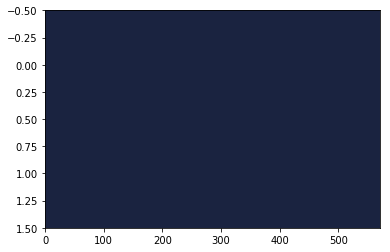

In [41]:
w = np.where(drc['type']=='dhd')[0]
cmap_dhd = ["#1a2340","#1a2340"]# +small_clust_colors
cmap_dhd = colors.LinearSegmentedColormap.from_list('cmap_dhd',cmap_dhd,len(w))
gradient = np.linspace(0, 1, len(w))
plt.imshow(np.vstack((gradient, gradient)), aspect='auto', cmap=cmap_dhd)
c_dhd = np.ones((1,len(w)))[0].reshape((-1,1))


In [44]:
!pip install dill
import dill
dill.dump_session('notebook_env.db')
dill.load_session('notebook_env.db')

  Stored in directory: C:\Users\noich\AppData\Local\pip\Cache\wheels\59\b1\91\f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
Successfully built dill


TypeError: no default __reduce__ due to non-trivial __cinit__

In [42]:
# print(to_cluster.embedding_[:, 0].max()-to_cluster.embedding_[:, 0].min())
# print(to_cluster.embedding_[:, 1].max()-to_cluster.embedding_[:, 1].min())

# drc['keywords'] = drc['title'].fillna('missing')
f_data = {'x': to_cluster[:,0], 'y': to_cluster[:,1],
          'c': clusterer.labels_,'labels':drc['tooltip'].str.replace('[^a-zA-Z0-9<>"=/ ,:;\.-]', '').values}
# <img src="econ_overlay_3.svg" id="overlay" alt="overlay" width="100%">
# <img src="dhd20.svg" id="overlay" alt="overlay" width="100%">
f = Faerun(title='', clear_color='#fcf8f2',
           coords=False, scale= 750,
           view='front',alpha_blending=True,
           anti_aliasing=True)

In [43]:
f.add_scatter('dhd20', f_data,  colormap=cmap,max_point_size=30,
              point_scale=2.2,shader="circle",fog_intensity=1,
                categorical=True)
f.add_scatter('dhd202',  {'x': to_cluster[w,0], 'y': to_cluster[w,1],'c':c_dhd[:,0],'labels':drc['tooltip'].str.replace('[^a-zA-Z0-9<>"=/ ,:;\.-]', '').values[w]},
              colormap=cmap_dhd,
             max_point_size=30,
              point_scale=2.6,shader="circle",fog_intensity=1,
                categorical=False)
f.add_scatter('dhd203', {'x': np.array([-2,20,20,-2]), 'y': np.array([-10,17,-10,17]),
          'c': np.array([0])},  colormap=cmap,saturation_limit = 0.4,
              point_scale=1.2,shader="circle",fog_intensity=0,
                categorical=True)



f.plot('dhd20_2',template='template_test.j2')

C:\ProgramData\Anaconda3\lib\site-packages\faerun\faerun.py:396: RuntimeWarning: invalid value encountered in true_divide
  data_c[s] = (data_c[s] - min_c[s]) / (max_c[s] - min_c[s])
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


C:\Users\noich\OneDrive\Desktop\dh_map\dhd20_2.html